In [354]:
from scipy.stats import percentileofscore as perc
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import json
import time

In [333]:
# Built from https://www.opendota.com/explorer
resp = requests.get('https://api.opendota.com/api/explorer?sql=SELECT%20*%0AFROM%20public_matches%0AWHERE%20public_matches.lobby_type%20%3D%207%0AAND%20public_matches.start_time%20>%3D%20extract(epoch%20from%20timestamp%20%272019-12-07T08%3A00%3A00.000Z%27)%0ALIMIT%201000000')


In [334]:
gendata = pd.DataFrame(json.loads(resp.content)['rows'])
gendata.head()

,avg_mmr,avg_rank_tier,cluster,duration,game_mode,lobby_type,match_id,match_seq_num,num_mmr,num_rank_tier,radiant_win,start_time
0,2908.0,44,136,2430,22,7,5145495206,4317375306,1.0,4,True,1575740434
1,NaN,21,191,1582,22,7,5145511618,4317375374,NaN,3,False,1575741250
2,2727.0,45,236,2783,22,7,5145489412,4317375475,3.0,6,False,1575740171
3,3745.0,62,201,2127,22,7,5145502416,4317375668,6.0,6,True,1575740753
4,2541.0,34,121,1426,22,7,5145515006,4317376119,1.0,2,True,1575741433


In [335]:
gendata = gendata.dropna(subset=['avg_mmr']).sample(10000)
gendata.head()

,avg_mmr,avg_rank_tier,cluster,duration,game_mode,lobby_type,match_id,match_seq_num,num_mmr,num_rank_tier,radiant_win,start_time
37692,3490.0,57,227,2233,3,7,5144911406,4316877672,4.0,7,True,1575718326
19892,2370.0,39,155,1864,22,7,5145837604,4317666952,1.0,2,False,1575763300
8559,2624.0,44,155,2649,22,7,5145646300,4317508313,1.0,4,False,1575748557
15479,2517.0,38,192,2125,22,7,5145760410,4317600316,3.0,5,False,1575756296
45908,4292.0,76,193,2993,22,7,5145065708,4317026073,6.0,7,True,1575724280


In [336]:
len(gendata)

10000

In [338]:
matchdata = defaultdict(list)
failed = []
resps = []
for i, mid in enumerate(gendata['match_id']):
    try:
        print('{:2.1%}'.format(i / 10000), end='\r')
        match = requests.get('https://api.opendota.com/api/matches/' + str(mid) + '[API KEY]')
        try:
            for key, val in json.loads(match.content).items():
                matchdata[key].append(val)
        except:
            failed.append(i)
            print('Failed: ' + str(i))
    except:
        print('SHIT: ' + str(i))

In [339]:
keys = []
for key in matchdata.keys():
    if len(matchdata[key]) == len(matchdata['match_id']):
        keys.append(key)
fixed = {key: matchdata[key] for key in keys}
data = pd.DataFrame(fixed)
data['avg_mmr'] = gendata['avg_mmr'].reset_index(drop=True)
data.to_csv('matchdata.csv')

In [283]:
gamemodedata = json.loads(requests.get('https://api.opendota.com/api/explorer?sql=SELECT%20*%0AFROM%20public_matches%0AWHERE%20public_matches.start_time%20>%3D%20extract(epoch%20from%20timestamp%20%272019-12-07T08%3A00%3A00.000Z%27)%0ALIMIT%20100000').content)
gamemodedata = pd.DataFrame(gamemodedata['rows'])

In [244]:
gamemodedata.head()

,avg_mmr,avg_rank_tier,cluster,duration,game_mode,lobby_type,match_id,match_seq_num,num_mmr,num_rank_tier,radiant_win,start_time
0,2908.0,44,136,2430,22,7,5145495206,4317375306,1.0,4,True,1575740434
1,NaN,21,191,1582,22,7,5145511618,4317375374,NaN,3,False,1575741250
2,2727.0,45,236,2783,22,7,5145489412,4317375475,3.0,6,False,1575740171
3,3745.0,62,201,2127,22,7,5145502416,4317375668,6.0,6,True,1575740753
4,2276.0,46,185,1335,22,0,5145516817,4317375840,3.0,5,True,1575741498


In [245]:
gamemodedata['lobby_type'].value_counts()

7    65198
0    14455
9     1075
1       40
Name: lobby_type, dtype: int64

In [246]:
modedata = gamemodedata['lobby_type'].value_counts()[:2]
modedata = modedata / np.sum(modedata)

In [247]:
modedata

7    0.818525
0    0.181475
Name: lobby_type, dtype: float64

In [248]:
modelist = []
modelist.append({'name': 'Ranked', 'y': modedata[7], 'sliced': True, 'selected': True})
modelist.append(['Normal', modedata[0]])
with open('./data/gametype_data.js', 'w') as outfile:
    outstring = "const gametypeSeries = " + json.dumps(modelist)
    outfile.write(outstring)

In [249]:
heroes = pd.DataFrame(json.loads(requests.get('https://api.opendota.com/api/heroes').content)).set_index('id', drop=True)
heroes.head()

,attack_type,legs,localized_name,name,primary_attr,roles
id,,,,,,
1,Melee,2,Anti-Mage,npc_dota_hero_antimage,agi,"[Carry, Escape, Nuker]"
2,Melee,2,Axe,npc_dota_hero_axe,str,"[Initiator, Durable, Disabler, Jungler]"
3,Ranged,4,Bane,npc_dota_hero_bane,int,"[Support, Disabler, Nuker, Durable]"
4,Melee,2,Bloodseeker,npc_dota_hero_bloodseeker,agi,"[Carry, Disabler, Jungler, Nuker, Initiator]"
5,Ranged,2,Crystal Maiden,npc_dota_hero_crystal_maiden,int,"[Support, Disabler, Nuker, Jungler]"


In [250]:
herodict = {i : heroes['localized_name'][i] for i in heroes.index}

In [340]:
herodata = {i: [] for i in herodict.values()}
mmrs = []
windata = []
losedata = []
for i, row in data.iterrows():
    radwin = row['radiant_win']
    winners = row['players'][0:5] if radwin else row['players'][5:10]
    losers = row['players'][5:10] if radwin else row['players'][1:5]
    for player in winners:
        herodata[herodict[player['hero_id']]].append(1)
    for player in losers:
        herodata[herodict[player['hero_id']]].append(0)
    

In [341]:
X = [x for x in list(herodata.keys()) if np.mean(herodata[x]) > 0.50]
y = [round(100 * np.mean(herodata[currx]), 1) for currx in X]
X = [x for _,x in sorted(zip(y,X), reverse=True)]
y = [{'name': 'Win Percentage', 'data': sorted(y, reverse=True)}]
with open('./data/hero_data.js', 'w') as outfile:
    outstring = "const heroCats = " + json.dumps(X) + "\n"
    outfile.write(outstring)
    outstring = "const heroData = " + json.dumps(y)
    outfile.write(outstring)

In [342]:
data.columns

Index(['match_id', 'barracks_status_dire', 'barracks_status_radiant', 'chat',
       'cluster', 'cosmetics', 'dire_score', 'dire_team_id', 'draft_timings',
       'duration', 'engine', 'first_blood_time', 'game_mode', 'human_players',
       'leagueid', 'lobby_type', 'match_seq_num', 'negative_votes',
       'objectives', 'picks_bans', 'positive_votes', 'radiant_gold_adv',
       'radiant_score', 'radiant_team_id', 'radiant_win', 'radiant_xp_adv',
       'skill', 'start_time', 'teamfights', 'tower_status_dire',
       'tower_status_radiant', 'version', 'players', 'patch', 'avg_mmr'],
      dtype='object')

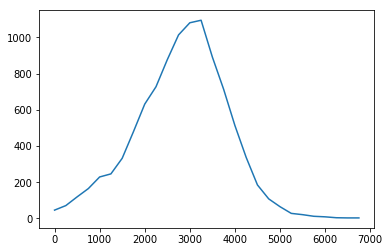

In [343]:
allmmrs = gendata['avg_mmr']
def binner(y_vals):
    y_binned = []
    for val in y_vals:
        y_binned.append(val // 250)
    return y_binned

binned = binner(allmmrs)
distr = pd.Series(binned).value_counts().sort_index()
distr.index = [i * 250 for i in distr.index]
plt.plot(distr)

In [344]:
distrlist = []
for i in distr.index:
    distrlist.append([int(i), round((int(distr[i]) / np.sum(distr)) * 100, 1)])

In [345]:
distrdata = [{
    'name': 'Percentage',
    'data': distrlist
}]
with open('./data/mmr_data.js', 'w') as outfile:
    outstring = "const mmrData = " + json.dumps(distrdata) + "\n"
    outfile.write(outstring)

In [346]:
cats = []
for i in range(0, 7500, 500):
    cats.append(str(i) + ' - ' + str(i + 500))

In [348]:
lhpm = {i: [] for i in range(15)}
gpm = {i: [] for i in range(15)}
xpm = {i: [] for i in range(15)}
kpm = {i: [] for i in range(15)}

In [349]:
for i, row in data.iterrows():
    if not row['avg_mmr']:
        print(i)
    else:
        mmrid = row['avg_mmr'] // 500
        radwin = row['radiant_win']
        winners = row['players'][0:5] if radwin else row['players'][5:10]
        lhs = []
        for player in winners:
            lhs.append(player['last_hits'])
        p1ind = pd.Series(lhs).idxmax()
        pdata = winners[p1ind]
        lhpm[mmrid].append(pdata['benchmarks']['gold_per_min']['pct'] * 100)
        gpm[mmrid].append(pdata['benchmarks']['xp_per_min']['pct'] * 100)
        xpm[mmrid].append(pdata['benchmarks']['last_hits_per_min']['pct'] * 100)
        kpm[mmrid].append(pdata['benchmarks']['kills_per_min']['pct'] * 100)

In [350]:
lhpmall = []
gpmall = []
xpmall = []
kpmall = []
for arr in lhpm.values():
    for ent in arr:
        lhpmall.append(ent)
for arr in gpm.values():
    for ent in arr:
        gpmall.append(ent)
for arr in xpm.values():
    for ent in arr:
        xpmall.append(ent)
for arr in kpm.values():
    for ent in arr:
        kpmall.append(ent)

In [355]:
mmrdata = []
for i in lhpm.keys():
    if len(lhpm[i]) == 0:
        continue
    mmrdata.append({
        'name': str(500 * i) + ' - ' + str((500 * i) + 499),
        'data': [perc(lhpmall, np.mean(lhpm[i]), kind='weak'),
                 perc(gpmall, np.mean(gpm[i]), kind='weak'),
                 perc(xpmall, np.mean(xpm[i]), kind='weak'),
                 perc(kpmall, np.mean(kpm[i]), kind='weak')]
    })

In [356]:
with open('./data/mmr_stats_data.js', 'w') as outfile:
    outstring = "const mmrStatsData = " + json.dumps(mmrdata)
    outfile.write(outstring)

In [362]:
for i in lhpm.keys():
    print(len(lhpm[i]))

117
284
475
811
1358
1889
2174
1604
850
293
93
33
13
6
0
